In [1]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

from tensorflow.keras import layers


In [2]:
(train_examples, validation_examples), info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    with_info=True,
    as_supervised=True,
)


In [3]:
def format_image(image, label):
    # `hub` image modules exepct their data normalized to the [0,1] range.
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label


num_examples = info.splits["train"].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches = (
    train_examples.cache()
    .shuffle(num_examples // 4)
    .map(format_image)
    .batch(BATCH_SIZE)
    .prefetch(1)
)
validation_batches = (
    validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)
)

In [4]:

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))


feature_extractor.trainable = False

model = tf.keras.Sequential([feature_extractor, layers.Dense(2)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [5]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

EPOCHS = 3
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)


Epoch 1/3
582/582 [==============================] - 426s 733ms/step - loss: 0.0568 - accuracy: 0.9802 - val_loss: 0.0322 - val_accuracy: 0.9880
Epoch 2/3
582/582 [==============================] - 461s 792ms/step - loss: 0.0308 - accuracy: 0.9889 - val_loss: 0.0312 - val_accuracy: 0.9893
Epoch 3/3
582/582 [==============================] - 458s 787ms/step - loss: 0.0244 - accuracy: 0.9913 - val_loss: 0.0305 - val_accuracy: 0.9903


In [6]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [7]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog',
       'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog',
       'cat', 'cat', 'cat', 'cat', 'cat'], dtype='<U3')

In [9]:
print("Actual Labels   : ", label_batch)
print("Predicted labels: ", predicted_ids)

Actual Labels   :  [1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0]
Predicted labels:  [1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0]


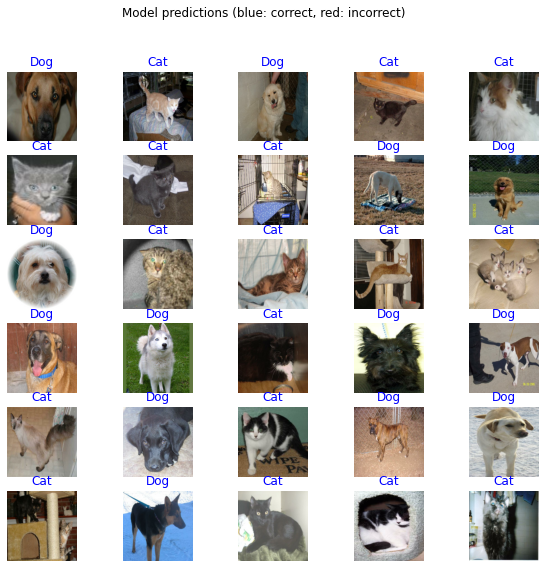

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [13]:
t = time.time()

export_path_keras = "./{}dogcat.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1602266416.h5


In [15]:
!ls

1602266416.h5
Fahrenheit to celsius using multiple dense layers.py
Fahrenheit to celsius using single dense layer.py
dogcatretraining.ipynb
dogvscat_transfer_learning.py
exercise_flowers_data_aug_cnn.py
fashion nmist tutorial 2.py
image classification using dense layer.py
image_classification_with_cnn.py
requirements.txt
test.ipynb
transferlearningcatsvsdogs.ipynb


In [16]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
(abs(result_batch - reloaded_result_batch)).max()

0.0

In [19]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

!ls {export_path_sm}

./1602266711
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./1602266711/assets
INFO:tensorflow:Assets written to: ./1602266711/assets
assets         saved_model.pb variables


In [20]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [21]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()
(abs(result_batch - reload_sm_result_batch)).max()

0.0

In [22]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)
(abs(result_batch - reload_sm_keras_result_batch)).max()

./1602271213
INFO:tensorflow:Assets written to: ./1602271213/assets
INFO:tensorflow:Assets written to: ./1602271213/assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


0.0

In [23]:
!zip -r model.zip {export_path_sm}

  adding: 1602271213/ (stored 0%)
  adding: 1602271213/variables/ (stored 0%)
  adding: 1602271213/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1602271213/variables/variables.index (deflated 78%)
  adding: 1602271213/saved_model.pb (deflated 92%)
  adding: 1602271213/assets/ (stored 0%)
